### The previous notebook was starting to get muddled, so I am creating a new one with the correct order:
     * dynamically winsorize data w moving average
     * optimize model hyperparameters 
     * compare to previous results

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit

In [3]:
st = st.Stocks()

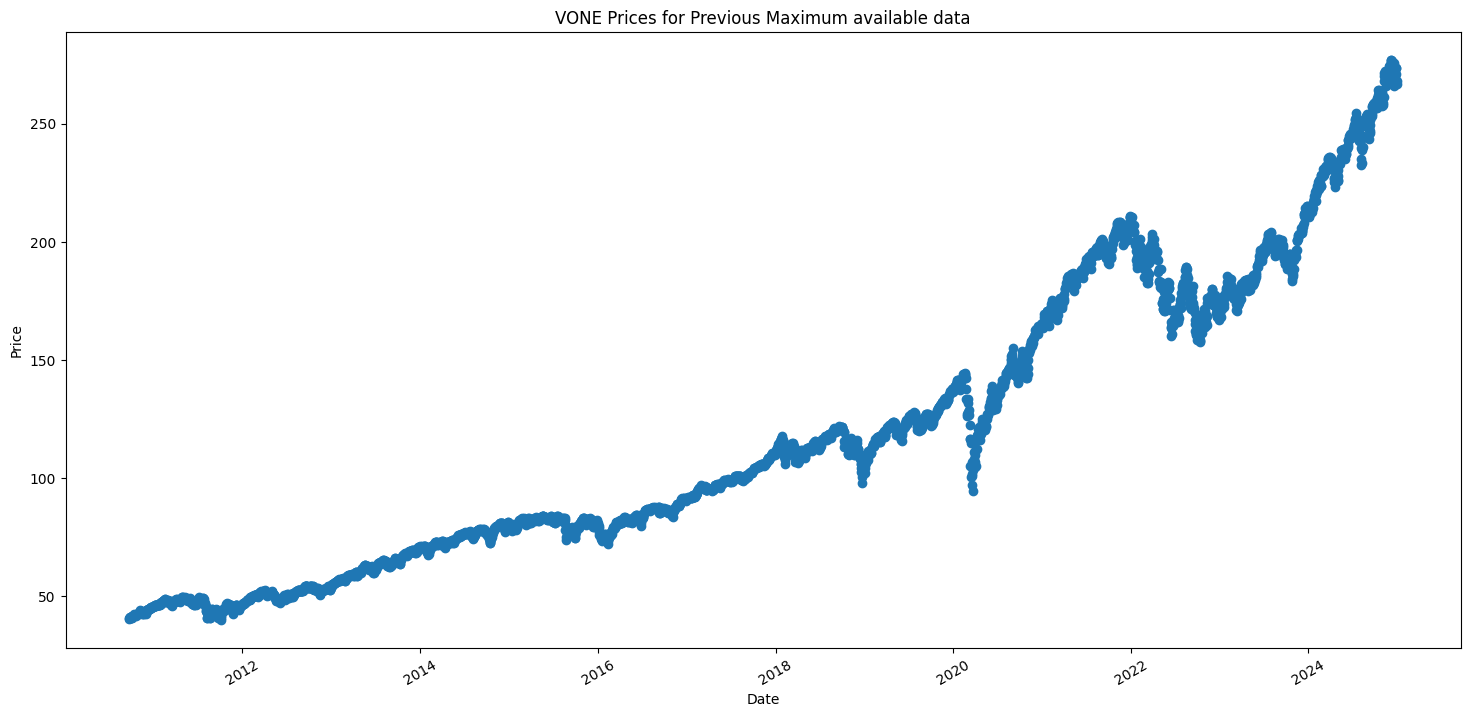

Closing price as of 2024-12-31: $266.72
The percentage change over previous Maximum available data is 552%
Dividends total $29.51
Stock Splits total $0.0
Capital Gains total $0.0


In [4]:
df = st.stats_generator('vone')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2010-09-22 00:00:00-04:00,40.895631,40.911409,40.611633,40.611633,50200,0.0,0.0,0.0
1,2010-09-23 00:00:00-04:00,40.280312,40.603754,40.193535,40.193535,13700,0.0,0.0,0.0
2,2010-09-24 00:00:00-04:00,40.658971,41.045521,40.658971,41.029743,22900,0.0,0.0,0.0
3,2010-09-27 00:00:00-04:00,41.092847,41.100735,40.903514,41.100735,24400,0.0,0.0,0.0
4,2010-09-28 00:00:00-04:00,40.706294,40.935070,40.706294,40.879848,6000,0.0,0.0,0.0


In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
def dynamic_winsorize(df, column, window_size=30, percentiles=(0.05, 0.95)):
    """
    Winsorizes data within a rolling window.

    Args:
        df: DataFrame containing the data.
        column: Name of the column to winsorize.
        window_size: Size of the rolling window.
        percentiles: Tuple containing the lower and upper percentiles.

    Returns:
        DataFrame with the winsorized column.
    """

    df['rolling_lower'] = df[column].rolling(window=window_size).quantile(percentiles[0])
    df['rolling_upper'] = df[column].rolling(window=window_size).quantile(percentiles[1])

    df['winsorized'] = df[column]
    df.loc[df[column] < df['rolling_lower'], 'winsorized'] = df['rolling_lower']
    df.loc[df[column] > df['rolling_upper'], 'winsorized'] = df['rolling_upper']

    return df

# Apply dynamic winsorization
df = dynamic_winsorize(df, 'Close')

In [8]:
df[df['Close'] != df['winsorized']].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,rolling_lower,rolling_upper,winsorized
29,2010-11-02,42.852042,42.923041,42.717933,42.844154,60400,0.0,0.0,0.0,40.650683,42.525070,42.525070
30,2010-11-03,42.725829,42.938828,42.670608,42.938828,1100,0.0,0.0,0.0,40.769402,42.702163,42.702163
31,2010-11-04,43.530499,43.656720,43.530499,43.640942,2300,0.0,0.0,0.0,40.866826,42.896225,42.896225
32,2010-11-05,43.893367,43.924923,43.893367,43.924923,1200,0.0,0.0,0.0,40.866826,43.324990,43.324990
33,2010-11-08,43.893383,43.940717,43.869718,43.877605,7000,0.0,0.0,0.0,40.866826,43.771107,43.771107


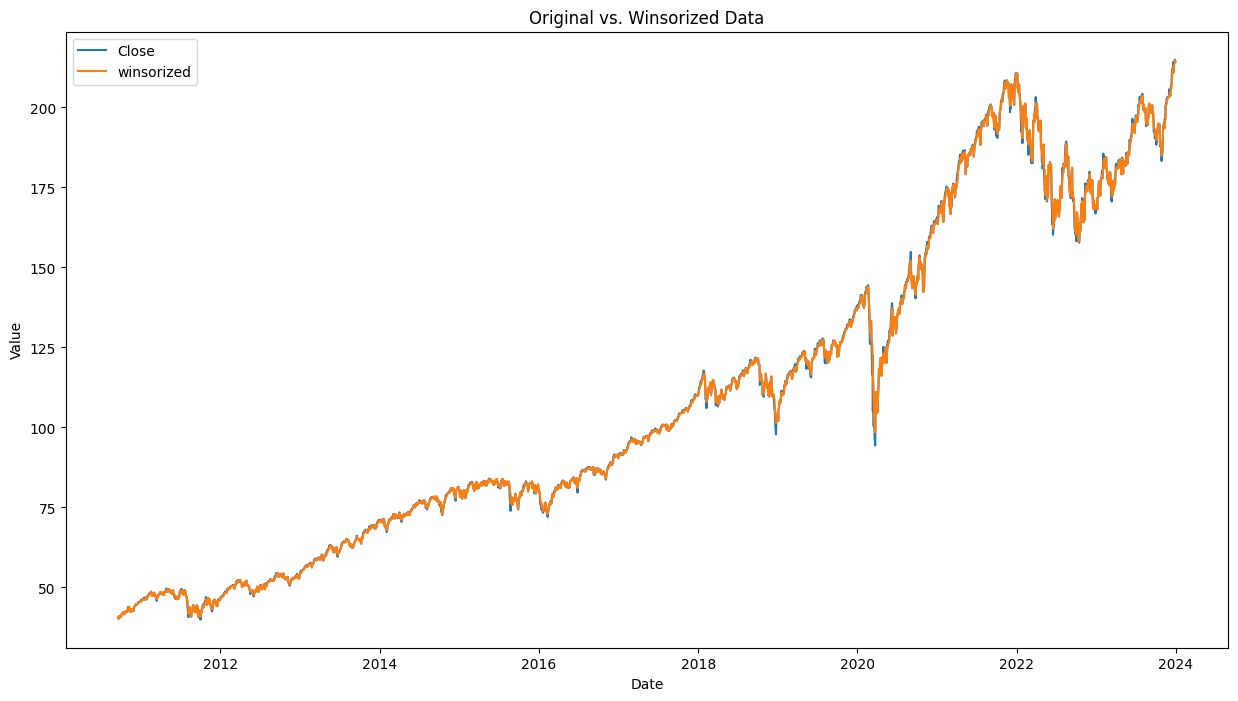

In [9]:
# zoomed view

import matplotlib.pyplot as plt
from datetime import date

# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2023, month=12, day=31)

# Filter the DataFrame based on the date range
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='Date', y=['Close', 'winsorized'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Winsorized Data')
plt.legend()

# Show the plot
plt.show()

### -- create a new baseline model --


In [10]:
# format new dataset for model with 'ds' and 'y'

df_train = df[['Date' ,'Close', 'winsorized']]
df_train = df_train.rename(columns={'Date': 'ds', 'winsorized': 'y'})

In [11]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_model_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-period:]
    y_pred = forecast['yhat'][-period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [12]:
%%time

period=365

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)

18:07:23 - cmdstanpy - INFO - Chain [1] start processing
18:07:24 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 354 ms, sys: 64.5 ms, total: 418 ms
Wall time: 1.14 s


In [13]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,33.378098,0.155833,1437.961432,37.920462


In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3953,2025-12-27,277.802312,258.156474,296.387292,260.679084,292.220892,-0.050670,-0.050670,-0.050670,-1.518091,-1.518091,-1.518091,1.467421,1.467421,1.467421,0.0,0.0,0.0,277.751642
3954,2025-12-28,277.882609,258.015665,295.650717,260.657427,292.370129,-0.064808,-0.064808,-0.064808,-1.518091,-1.518091,-1.518091,1.453283,1.453283,1.453283,0.0,0.0,0.0,277.817801
3955,2025-12-29,277.962905,260.596506,298.311440,260.639685,292.513928,2.166659,2.166659,2.166659,0.730637,0.730637,0.730637,1.436022,1.436022,1.436022,0.0,0.0,0.0,280.129564
3956,2025-12-30,278.043201,259.892872,299.126935,260.622112,292.657727,2.083343,2.083343,2.083343,0.667957,0.667957,0.667957,1.415386,1.415386,1.415386,0.0,0.0,0.0,280.126544
3957,2025-12-31,278.123497,260.217300,298.335891,260.604539,292.801527,1.900441,1.900441,1.900441,0.509246,0.509246,0.509246,1.391195,1.391195,1.391195,0.0,0.0,0.0,280.023939


### -- for fun, i want to compare yhat with actual Close now --

In [15]:
forecast['actual_close'] = df.Close

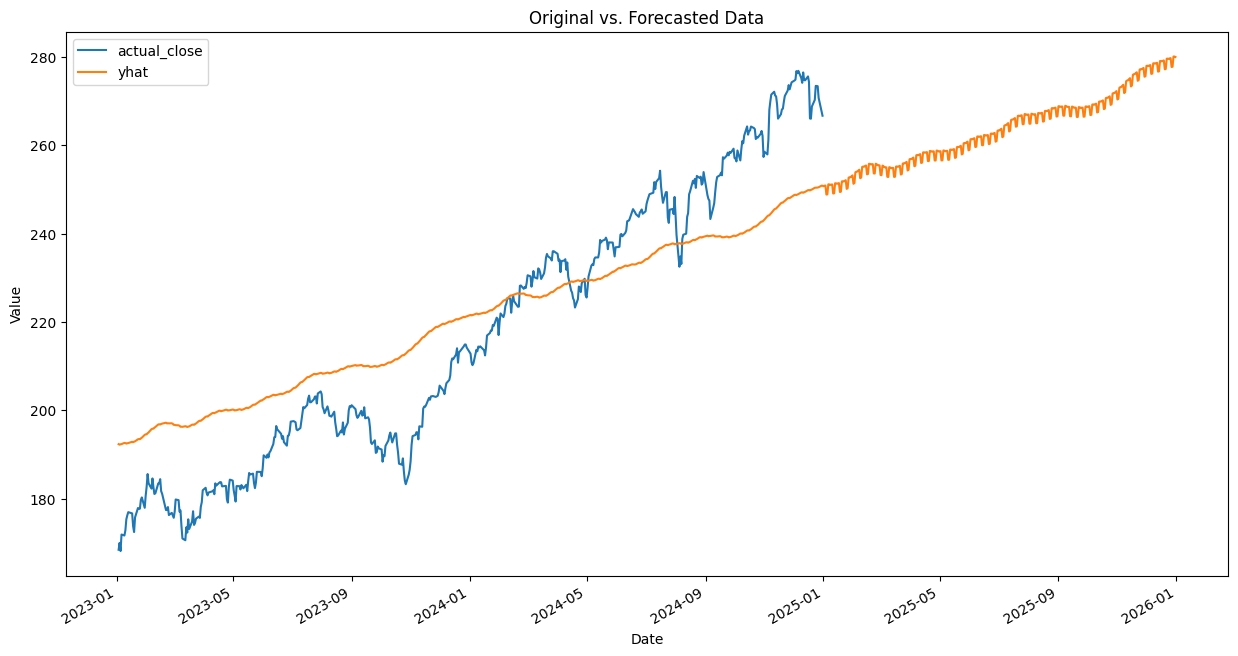

In [16]:
# Define the desired date range
start_date = date(year=2023, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

### -- Cross Validation w Grid Search --

In [17]:
%%time
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Define hyperparameter grid
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], 
    'seasonality_prior_scale': [0.1, 1, 10] 
}

best_params = None
best_score = float('inf') 

for seasonality_mode in param_grid['seasonality_mode']:
    for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
        for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
            # Create and fit the model
            m = Prophet(
                seasonality_mode=seasonality_mode,
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale
            )
        m.fit(df_train)
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days') 
        df_p = performance_metrics(df_cv)
        score = df_p['rmse'].mean() 

        if score < best_score:
            best_score = score
            best_params = {
                'seasonality_mode': seasonality_mode,
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale
                        }

18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/23 [00:00<?, ?it/s]

18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:32 - cmdstanpy - INFO - Chain [1] done processing
18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:32 - cmdstanpy - INFO - Chain [1] done processing
18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:32 - cmdstanpy - INFO - Chain [1] done processing
18:07:33 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing
18:07:33 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

18:07:46 - cmdstanpy - INFO - Chain [1] start processing
18:07:46 - cmdstanpy - INFO - Chain [1] done processing
18:07:46 - cmdstanpy - INFO - Chain [1] start processing
18:07:47 - cmdstanpy - INFO - Chain [1] done processing
18:07:47 - cmdstanpy - INFO - Chain [1] start processing
18:07:48 - cmdstanpy - INFO - Chain [1] done processing
18:07:48 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:52 - cmdstanpy - INFO - Chain [1] done processing
18:07:52 - cmdstanpy - INFO - Chain [1] start processing
18:07:53 - cmdstanpy - INFO - Chain [1] done processing
18:07:53 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1]

CPU times: user 19.6 s, sys: 2.64 s, total: 22.3 s
Wall time: 1min 57s


In [18]:
# Train the final model with the best hyperparameters
final_model = Prophet(**best_params)
final_model.fit(df_train)

18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 10}

In [20]:
%%time
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

  0%|          | 0/23 [00:00<?, ?it/s]

18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1]

CPU times: user 2.35 s, sys: 305 ms, total: 2.65 s
Wall time: 4.44 s


In [21]:
print(df_p.mean())

horizon     201 days 00:00:00
mse                342.883022
rmse                18.206778
mae                 13.197871
mape                 0.091717
mdape                0.078236
smape                0.093302
coverage             0.297522
dtype: object


In [22]:
future = final_model.make_future_dataframe(periods=period)
forecast = final_model.predict(future)

In [23]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,21.396168,0.101393,700.697806,26.470697


In [24]:
forecast['actual_close'] = df.Close

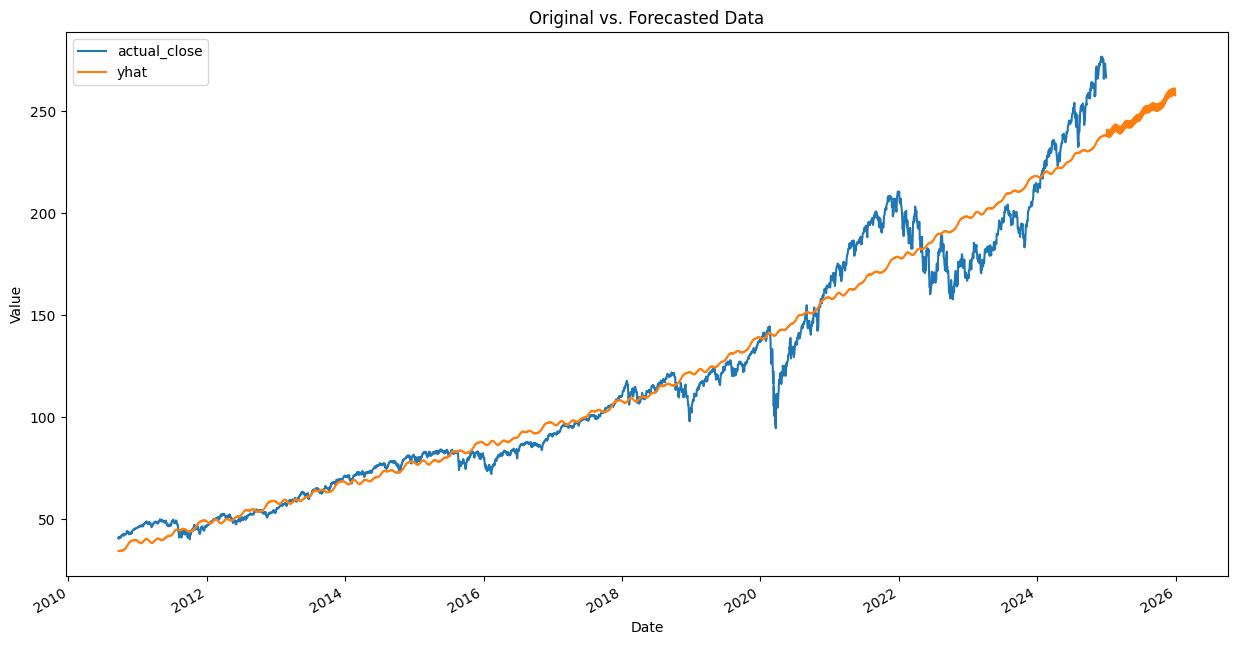

In [25]:
# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

In [26]:
# visualize

# Plot Forecast
fig1 = plot_plotly(m, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price')
fig1.update_layout(xaxis_title='Date')
# ADD LEGEND <<<<<
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### follow up
* gme mape results are 7.97% better with winsorization than just grid search and cross-validation! (0.310355 vs 0.390088)
    * winsorized model is 25.95% better mape than un-tuned model (0.310355 vs 0.569809)
* figure out what performance_metrics() does to calculate metrics. it is wildly different than get_model_accuracy()
    * get_model_accuracy() measures the error outside of the forecast
    * performance_metrics() measures error from cross-validation
* why is the model just a straight line? like obviously theres a pattern but it doesn't match well with actual price. or is it just GME?
    * i think this got graphed incorrectly.

* evaluate dataset (for volitility?) and put out the best model for that data